# **VADER (Lexicon Based Approach)**

### Importing Packages 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels
import numpy as np
import itertools
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import re

# Download NLTK resources if not already downloaded
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\saman\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\saman\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\saman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Loading Dataset 

In [2]:
# Load the dataset
df = pd.read_csv("downsampled_dataset_10k.csv")

In [3]:
print(df.shape)
df.head()

(9999, 16)


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,sentiment
0,US,6108596,RN8YG8Q0AS227,B00P8LFJ3Y,406643994,Lava HD-8000 OmniPro,Electronics,5,0,0,N,Y,Five Stars,Great tv signal very good buy.I like it,2015-08-21,Positive
1,US,37870958,R1U4X7M4TMY84A,B00WBS32K4,527761468,PonoMusic Pono Portable Music Player,Electronics,5,1,2,N,Y,Five Stars,Good sound. Fine Material. Simply perfect!,2015-08-29,Positive
2,US,38204831,R291XVGVS56XGR,B00XVT4DLO,80192107,DIVOIX® DV110 In-Ear Headphone Earbuds Lightwe...,Electronics,5,0,0,N,Y,Five Stars,looks good as shown lots of base. BTW fast shi...,2015-08-22,Positive
3,US,26611731,R2Y9PUSXVAMOUU,B00N1KWERI,97589125,"Eclipse 8GB 2.8"" Supra Fit Bluetooth MP3 with ...",Electronics,5,0,0,N,Y,Love it!,This player is totally awesome! I has all the ...,2015-08-18,Positive
4,US,47611641,R1O2U9QMV39FK2,B004LTEUDO,533949740,Mediabridge 3.5mm Male To Male Stereo Audio Ca...,Electronics,5,0,0,N,Y,High Quality Cable,Very quick delivery and high quality. Sound is...,2015-08-20,Positive


In [4]:
# Actually we only need the content(i.e. review) & the sentiment score for classification
df = df[["review_body", "sentiment"]]
df.head()

,review_body,sentiment
0,Great tv signal very good buy.I like it,Positive
1,Good sound. Fine Material. Simply perfect!,Positive
2,looks good as shown lots of base. BTW fast shi...,Positive
3,This player is totally awesome! I has all the ...,Positive
4,Very quick delivery and high quality. Sound is...,Positive


# **Text Preprocessing**

In [5]:
def remove_punctuation(text):
    text = str(text)
    punctiations = string.punctuation
    return text.translate(str.maketrans('', '', punctiations))

def remove_spec_char(text):
    text = str(text)
    text = re.sub('[^a-zA-Z0-9]', ' ', text)
    text = re.sub('\s+', ' ', text)
    return text

# lowercase words
df["review_body"] = df["review_body"].str.lower()

# remove punctuation
df["review_body"] = df["review_body"].apply(remove_punctuation)

# remove special characters
df["review_body"] = df["review_body"].apply(remove_spec_char)

## Applying VADER 

In [6]:

# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Perform sentiment analysis on preprocessed text
def get_sentiment_score(text):
    scores = sia.polarity_scores(text)
    return scores['compound']

# Apply sentiment analysis to 'clean_text' column
df['sentiment_score'] = df["review_body"].apply(get_sentiment_score)

# Determine sentiment label based on sentiment score
def get_sentiment_label(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment label to 'sentiment_score' column
df['pred_sentiment_label'] = df['sentiment_score'].apply(get_sentiment_label)

df["polarity_score_pos"] = df["review_body"].apply(lambda x: sia.polarity_scores(x)["neg"])

# Print the DataFrame with sentiment scores and labels
print(df[["review_body", 'sentiment_score', 'pred_sentiment_label']])


                                            review_body  sentiment_score  \
0                great tv signal very good buyi like it           0.8766   
1               good sound fine material simply perfect           0.8126   
2     looks good as shown lots of base btw fast ship...           0.7964   
3     this player is totally awesome i has all the f...           0.8439   
4     very quick delivery and high quality sound is ...           0.8612   
...                                                 ...              ...   
9994  videoidb4bca62c488cf53627fffb70aae70367this mp...           0.6371   
9995                                broken in one month          -0.4767   
9996           it was the same as the oem one i removed           0.0000   
9997  exceeded my expectations they were high easy t...           0.6808   
9998                            great cable super cheap           0.8402   

     pred_sentiment_label  
0                Positive  
1                Positive  
2  

In [7]:
# Adding polarity scores (pos, neg, neu) in dataframe 
df["polarity_score_pos"] = df["review_body"].apply(lambda x: sia.polarity_scores(x)["pos"])
df["polarity_score_neu"] = df["review_body"].apply(lambda x: sia.polarity_scores(x)["neu"])
df["polarity_score_neg"] = df["review_body"].apply(lambda x: sia.polarity_scores(x)["neg"])

In [8]:
df.head(25)

,review_body,sentiment,sentiment_score,pred_sentiment_label,polarity_score_pos,polarity_score_neu,polarity_score_neg
0,great tv signal very good buyi like it,Positive,0.8766,Positive,0.668,0.332,0.000
1,good sound fine material simply perfect,Positive,0.8126,Positive,0.737,0.263,0.000
2,looks good as shown lots of base btw fast ship...,Positive,0.7964,Positive,0.321,0.679,0.000
3,this player is totally awesome i has all the f...,Positive,0.8439,Positive,0.327,0.603,0.070
4,very quick delivery and high quality sound is ...,Positive,0.8612,Positive,0.389,0.611,0.000
5,awesome,Positive,0.6249,Positive,1.000,0.000,0.000
6,extremely nice quality especially for the pric...,Positive,0.6361,Positive,0.149,0.788,0.062
7,identical to the one from verizon that we some...,Positive,0.7082,Positive,0.160,0.840,0.000
8,these are so handy and sound really awesome pe...,Positive,0.8545,Positive,0.411,0.589,0.000
9,works great,Positive,0.6249,Positive,0.804,0.196,0.000


In [9]:

# Compute f1_score
f1_score = f1_score(df['sentiment'], df['pred_sentiment_label'], average = "weighted")


# Print f1_score
print("F1_score:", f1_score)

# Compute precision, recall, and F1-score
report = classification_report(df['sentiment'], df['pred_sentiment_label'])
print("\nClassification Report:")
print(report)


F1_score: 0.7601371487550542

Classification Report:
              precision    recall  f1-score   support

    Negative       0.60      0.48      0.53      1680
     Neutral       0.10      0.17      0.12       684
    Positive       0.88      0.86      0.87      7635

    accuracy                           0.75      9999
   macro avg       0.52      0.50      0.51      9999
weighted avg       0.78      0.75      0.76      9999



In [10]:
# function for evaluation(confusion matrix)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

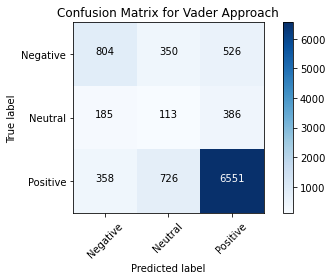

In [11]:
# Create a confusion matrix and plot it
cm = confusion_matrix(df['sentiment'], df['pred_sentiment_label'])
plot_confusion_matrix(cm, classes = unique_labels(df['sentiment']), title = "Confusion Matrix for Vader Approach")